## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, pos_tag

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
#random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:20])

3718
196
[[('The', 'DET'), ('offer', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-2', 'X'), ('was', 'VERB'), ('due', 'ADJ'), ('*-3', 'X'), ('to', 'PRT'), ('expire', 'VERB'), ('yesterday', 'NOUN'), (',', '.'), ('is', 'VERB'), ('conditional', 'ADJ'), ('on', 'ADP'), ('50.1', 'NUM'), ('%', 'NOUN'), ('of', 'ADP'), ("Dunkin'", 'NOUN'), ('common', 'ADJ'), ('shares', 'NOUN'), (',', '.'), ('on', 'ADP'), ('a', 'DET'), ('fully', 'ADV'), ('diluted', 'VERB'), ('basis', 'NOUN'), (',', '.'), ('being', 'VERB'), ('tendered', 'VERB'), ('*-1', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('the', 'DET'), ('withdrawal', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('company', 'NOUN'), ("'s", 'PRT'), ('poison', 'NOUN'), ('pill', 'NOUN'), ('rights', 'NOUN'), ('plan', 'NOUN'), ('.', '.')], [('The', 'DET'), ('len', 'NOUN'), ("'s", 'PRT'), ('foldability', 'NOUN'), ('enables', 'VERB'), ('it', 'PRON'), ('to', 'PRT'), ('be', 'VERB'), ('inserted', 'VERB'), ('*-1', 'X'), ('in', 'ADP'), ('smaller', 'ADJ'), ('incisions', 'NOUN'),

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print(len(train_tagged_words))
test_tagged_words = [tup for sent in test_set for tup in sent]
print(len(test_tagged_words))

95360
5316


In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The', 'offer', ',', 'which', '*T*-2', 'was', 'due', '*-3', 'to', 'expire']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12064


In [8]:
# number of tags to verify if we have 12 tags as mentioned in Problem statement
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [9]:
print(T)

{'ADP', 'PRT', 'NUM', 'ADJ', 'NOUN', '.', 'VERB', 'CONJ', 'X', 'ADV', 'PRON', 'DET'}


## POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [10]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [12]:
# testing the code with examples

# large
print("\n", "The")
print(word_given_tag('The', 'DET'))
print(word_given_tag('The', 'VERB'))
print(word_given_tag('The', 'NOUN'), "\n")

# will
print("\n", "problem")
print(word_given_tag('problem', 'VERB'))
print(word_given_tag('problem', 'NOUN'))
print(word_given_tag('problem', 'ADJ'))

# book
print("\n", "involves")
print(word_given_tag('involves', 'NOUN'))
print(word_given_tag('involves', 'VERB'))
print(word_given_tag('involves', 'CONJ'))


 The
(681, 8265)
(0, 12823)
(4, 27269) 


 problem
(0, 12823)
(29, 27269)
(0, 6076)

 involves
(0, 27269)
(2, 12823)
(0, 2155)


### Transition Probabilities

In [13]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# examples
print(t2_given_t1(t2='NOUN', t1='DET'))
print(t2_given_t1('NOUN', 'ADP'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('PRON', 'NOUN'))
print(t2_given_t1(',', 'PRON'))
print(t2_given_t1('PRON', 'NOUN'))
print(t2_given_t1('VERB', 'PRON'))

(5275, 8265)
(2997, 9320)
(1417, 12823)
(127, 27269)
(0, 2614)
(127, 27269)
(1280, 2614)


In [15]:
# Checking the transition with start words herein (.)
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('PRON', '.'))

(1924, 11142)
(979, 11142)
(2462, 11142)
(742, 11142)


In [16]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [17]:
tags_matrix

array([[1.69527903e-02, 1.50214590e-03, 6.22317605e-02, 1.06652364e-01,
        3.21566522e-01, 4.09871228e-02, 8.04721005e-03, 8.58369109e-04,
        3.45493555e-02, 1.36266090e-02, 6.92060068e-02, 3.23819757e-01],
       [2.10042670e-02, 1.96915003e-03, 5.74335419e-02, 8.53298306e-02,
        2.46471941e-01, 4.33213003e-02, 4.00393844e-01, 1.64095836e-03,
        1.34558585e-02, 9.51755792e-03, 1.77223496e-02, 1.01739414e-01],
       [3.50825489e-02, 2.68278308e-02, 1.86615571e-01, 3.30188684e-02,
        3.51709902e-01, 1.13797173e-01, 1.79834906e-02, 1.35613205e-02,
        2.14327827e-01, 2.65330193e-03, 1.47405663e-03, 2.94811325e-03],
       [7.73535222e-02, 1.08624091e-02, 2.09019091e-02, 6.68202788e-02,
        6.98321283e-01, 6.46807104e-02, 1.25082294e-02, 1.71165243e-02,
        2.12310739e-02, 4.44371300e-03, 6.58327830e-04, 5.10204071e-03],
       [1.76354095e-01, 4.38593291e-02, 9.68132354e-03, 1.21749975e-02,
        2.62459189e-01, 2.41042942e-01, 1.47236794e-01, 4.32

In [18]:
# convert the matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,ADP,PRT,NUM,ADJ,NOUN,.,VERB,CONJ,X,ADV,PRON,DET
ADP,0.016953,0.001502,0.062232,0.106652,0.321567,0.040987,0.008047,0.000858,0.034549,0.013627,0.069206,0.323820
PRT,0.021004,0.001969,0.057434,0.085330,0.246472,0.043321,0.400394,0.001641,0.013456,0.009518,0.017722,0.101739
NUM,0.035083,0.026828,0.186616,0.033019,0.351710,0.113797,0.017983,0.013561,0.214328,0.002653,0.001474,0.002948
ADJ,0.077354,0.010862,0.020902,0.066820,0.698321,0.064681,0.012508,0.017117,0.021231,0.004444,0.000658,0.005102
NOUN,0.176354,0.043859,0.009681,0.012175,0.262459,0.241043,0.147237,0.043236,0.028677,0.017236,0.004657,0.013385
.,0.091187,0.002423,0.082481,0.044426,0.220966,0.094507,0.087866,0.057530,0.026656,0.052594,0.066595,0.172680
VERB,0.091632,0.031974,0.022772,0.065117,0.110505,0.034781,0.168213,0.005225,0.217110,0.082040,0.035951,0.134680
CONJ,0.052900,0.005104,0.041299,0.117865,0.349884,0.035731,0.154988,0.000464,0.008817,0.055684,0.058933,0.118329
X,0.143839,0.183794,0.002717,0.017580,0.061211,0.165734,0.203292,0.010388,0.075116,0.024932,0.056097,0.055298
ADV,0.119000,0.014000,0.032000,0.131000,0.031000,0.137333,0.343333,0.007000,0.022333,0.078000,0.015333,0.069667


In [19]:
tags_df.loc['.', :]

ADP     0.091187
PRT     0.002423
NUM     0.082481
ADJ     0.044426
NOUN    0.220966
.       0.094507
VERB    0.087866
CONJ    0.057530
X       0.026656
ADV     0.052594
PRON    0.066595
DET     0.172680
Name: ., dtype: float32

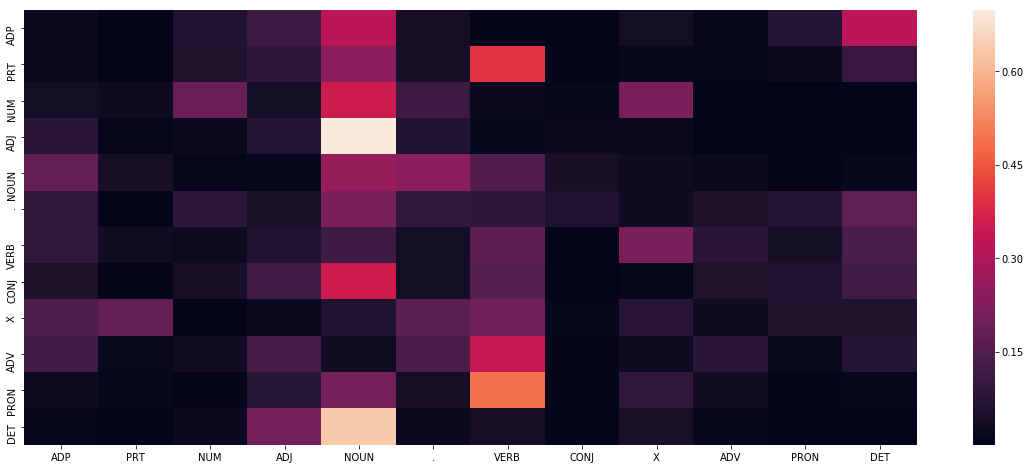

In [20]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(20, 8))
sns.heatmap(tags_df)
plt.show()

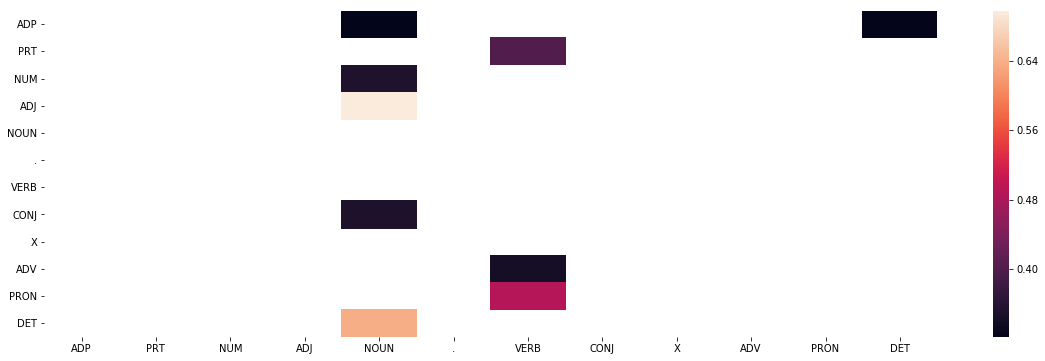

In [21]:
# frequent tags
# filter the df to get P(t2, t1) > 0.3 (consdering the average of probabilities in the dataframe)
tags_frequent = tags_df[tags_df>0.3]
plt.figure(figsize=(20, 6))
sns.heatmap(tags_frequent)
plt.show()

#### As per above graph. Most transition probability can be observed between NOUN and other vocablories.

### Build the vanilla Viterbi based POS tagger

In [22]:
len(train_tagged_words)

95360

In [23]:
# Viterbi Heuristic
def VanillaViterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Test Set Evaluation

In [24]:
# Running on entire test dataset is taking more than half an hour 
# Hence, Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run


[[('Terms', 'NOUN'),
  ('were', 'VERB'),
  ("n't", 'ADV'),
  ('disclosed', 'VERB'),
  ('*-1', 'X'),
  ('.', '.')],
 [('``', '.'),
  ('U.S.', 'NOUN'),
  ('investors', 'NOUN'),
  ('should', 'VERB'),
  ('have', 'VERB'),
  ('a', 'DET'),
  ('greater', 'ADJ'),
  ('opportunity', 'NOUN'),
  ('at', 'ADP'),
  ('direct', 'ADJ'),
  ('investment', 'NOUN'),
  ("''", '.'),
  ('in', 'ADP'),
  ('Japan', 'NOUN'),
  ('.', '.')],
 [('According', 'VERB'),
  ('to', 'PRT'),
  ('reports', 'NOUN'),
  ('carried', 'VERB'),
  ('*', 'X'),
  ('by', 'ADP'),
  ('various', 'ADJ'),
  ('news', 'NOUN'),
  ('services', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Brazilian', 'ADJ'),
  ('government', 'NOUN'),
  ('told', 'VERB'),
  ('its', 'PRON'),
  ('sugar', 'NOUN'),
  ('producers', 'NOUN'),
  ('that', 'ADP'),
  ('they', 'PRON'),
  ('wo', 'VERB'),
  ("n't", 'ADV'),
  ('be', 'VERB'),
  ('allowed', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('export', 'VERB'),
  ('sugar', 'NOUN'),
  ('during', 'ADP'),
  ('the', 'DET'),
  (

In [25]:
# tagging the test sentences
start = time.time()
van_tagged_seq = VanillaViterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(van_tagged_seq)
#print(test_run_base)

Time taken in seconds:  57.11030125617981
[('Terms', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('disclosed', 'VERB'), ('*-1', 'X'), ('.', '.'), ('``', '.'), ('U.S.', 'NOUN'), ('investors', 'NOUN'), ('should', 'VERB'), ('have', 'VERB'), ('a', 'DET'), ('greater', 'ADJ'), ('opportunity', 'NOUN'), ('at', 'ADP'), ('direct', 'ADJ'), ('investment', 'NOUN'), ("''", '.'), ('in', 'ADP'), ('Japan', 'NOUN'), ('.', '.'), ('According', 'VERB'), ('to', 'PRT'), ('reports', 'NOUN'), ('carried', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('various', 'ADJ'), ('news', 'NOUN'), ('services', 'NOUN'), (',', '.'), ('the', 'DET'), ('Brazilian', 'ADJ'), ('government', 'NOUN'), ('told', 'VERB'), ('its', 'PRON'), ('sugar', 'NOUN'), ('producers', 'NOUN'), ('that', 'ADP'), ('they', 'PRON'), ('wo', 'VERB'), ("n't", 'ADV'), ('be', 'VERB'), ('allowed', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('export', 'NOUN'), ('sugar', 'NOUN'), ('during', 'ADP'), ('the', 'DET'), ('current', 'ADJ'), ('1989-90', 'NUM'), ('season', 'NOUN'), ('

In [26]:
# accuracy
check = [i for i, j in zip(van_tagged_seq, test_run_base) if i == j] 
vanillaViterbiAccuracy = len(check)/len(van_tagged_seq)
vanillaViterbiAccuracy

0.9437229437229437

In [27]:
vanilla_incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(van_tagged_seq, test_run_base)) if j[0]!=j[1]]
vanilla_incorrect_tagged_cases

[[('to', 'PRT'), (('export', 'NOUN'), ('export', 'VERB'))],
 [('the', 'DET'), (('1990-91', 'ADP'), ('1990-91', 'NUM'))],
 [('season', 'NOUN'), (('so', 'ADV'), ('so', 'ADP'))],
 [('for', 'ADP'), (('automobile', 'ADP'), ('automobile', 'NOUN'))],
 [('for', 'ADP'), (('nondurable', 'ADP'), ('nondurable', 'ADJ'))],
 [('to', 'PRT'), (('last', 'ADJ'), ('last', 'VERB'))],
 [('$', '.'), (('109.73', 'ADP'), ('109.73', 'NUM'))],
 [('*U*', 'X'), (('after', 'ADP'), ('after', 'ADV'))],
 [('month', 'NOUN'), (('before', 'ADP'), ('before', 'ADV'))],
 [('.', '.'), (('Superconductors', 'ADP'), ('Superconductors', 'NOUN'))],
 [('Superconductors', 'NOUN'), (('conduct', 'NOUN'), ('conduct', 'VERB'))],
 [('year', 'NOUN'), (('earlier', 'ADV'), ('earlier', 'ADJ'))],
 [('tight', 'ADJ'), (('facial', 'ADP'), ('facial', 'ADJ'))]]

In [28]:
incorrect_words = [w[0] for in_wo in vanilla_incorrect_tagged_cases for w in in_wo]
set(incorrect_words)

{'$',
 ('109.73', 'ADP'),
 ('1990-91', 'ADP'),
 ('Superconductors', 'ADP'),
 ('after', 'ADP'),
 ('automobile', 'ADP'),
 ('before', 'ADP'),
 ('conduct', 'NOUN'),
 ('earlier', 'ADV'),
 ('export', 'NOUN'),
 ('facial', 'ADP'),
 ('last', 'ADJ'),
 ('nondurable', 'ADP'),
 ('so', 'ADV'),
 '*U*',
 '.',
 'Superconductors',
 'for',
 'month',
 'season',
 'the',
 'tight',
 'to',
 'year'}

### Solve the problem of unknown words

#### Approach 1 : Marking default transition probability on unknown words, by modifying the Viterbi Algorithm, wherien if the state of the word is zero then use rule engine to tag vocablory to the words

In [29]:
def TransitionViterbi(words, train_bag = train_tagged_words) :
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    V=[i[0] for i in train_bag]
    
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1] 
            
            ## Here if the given word vocablory is present in the train vocab. 
            ## then calculate state probability, else default to transition
            if words[key] in V:
                state_probability = emission_p * transition_p
            else:
                state_probability = transition_p    #Considering only the transition prob as emission will be zero        
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        
        state.append(state_max)      
    return list(zip(words, state))

In [30]:
# tagging the test sentences with Transition Viterbi Algorithm
start = time.time()
tran_tagged_seq = TransitionViterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tran_tagged_seq)

Time taken in seconds:  56.13119649887085
[('Terms', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('disclosed', 'VERB'), ('*-1', 'X'), ('.', '.'), ('``', '.'), ('U.S.', 'NOUN'), ('investors', 'NOUN'), ('should', 'VERB'), ('have', 'VERB'), ('a', 'DET'), ('greater', 'ADJ'), ('opportunity', 'NOUN'), ('at', 'ADP'), ('direct', 'ADJ'), ('investment', 'NOUN'), ("''", '.'), ('in', 'ADP'), ('Japan', 'NOUN'), ('.', '.'), ('According', 'VERB'), ('to', 'PRT'), ('reports', 'NOUN'), ('carried', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('various', 'ADJ'), ('news', 'NOUN'), ('services', 'NOUN'), (',', '.'), ('the', 'DET'), ('Brazilian', 'ADJ'), ('government', 'NOUN'), ('told', 'VERB'), ('its', 'PRON'), ('sugar', 'NOUN'), ('producers', 'NOUN'), ('that', 'ADP'), ('they', 'PRON'), ('wo', 'VERB'), ("n't", 'ADV'), ('be', 'VERB'), ('allowed', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('export', 'NOUN'), ('sugar', 'NOUN'), ('during', 'ADP'), ('the', 'DET'), ('current', 'ADJ'), ('1989-90', 'NUM'), ('season', 'NOUN'), ('

In [31]:
check = [i for i, j in zip(tran_tagged_seq, test_run_base) if i == j] 
TransitionViterbiAccuracy = len(check)/len(tran_tagged_seq)
print(TransitionViterbiAccuracy)

0.9523809523809523


In [32]:
transition_incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tran_tagged_seq, test_run_base)) if j[0]!=j[1]]
transition_incorrect_tagged_cases

[[('to', 'PRT'), (('export', 'NOUN'), ('export', 'VERB'))],
 [('the', 'DET'), (('1990-91', 'NOUN'), ('1990-91', 'NUM'))],
 [('season', 'NOUN'), (('so', 'ADV'), ('so', 'ADP'))],
 [('for', 'ADP'), (('automobile', 'DET'), ('automobile', 'NOUN'))],
 [('for', 'ADP'), (('nondurable', 'DET'), ('nondurable', 'ADJ'))],
 [('to', 'PRT'), (('last', 'ADJ'), ('last', 'VERB'))],
 [('$', '.'), (('109.73', 'NOUN'), ('109.73', 'NUM'))],
 [('*U*', 'X'), (('after', 'ADP'), ('after', 'ADV'))],
 [('month', 'NOUN'), (('before', 'ADP'), ('before', 'ADV'))],
 [('year', 'NOUN'), (('earlier', 'ADV'), ('earlier', 'ADJ'))],
 [('tight', 'ADJ'), (('facial', 'NOUN'), ('facial', 'ADJ'))]]

#### Approach 2 : Running Rule Based engine on unknown words, by modifying the Viterbi Algorithm, wherien if the state of the word is zero then use rule engine to tag vocablory to the words

In [33]:
def RuleBasedViterbi_old(words, train_bag = train_tagged_words, backoff=[]):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        e=[]
        t=[]
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            t.append(transition_p)
            e.append(emission_p) #Adding Emission prbability for all tag
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        state_max = None
        if pmax == 0.0:
            stack = backoff.copy()
            while stack != []:
                if state_max==None:
                    state_max=stack.pop()([word])[0][1]
                else:
                    stack.clear()
            if state_max == None and backoff != []:
                if sum(e)==0.0:
                    state_max = T[t.index(max(t))]
        # getting state for which probability is maximum
        if state_max==None:
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [34]:
def RuleBasedViterbi(incorrect_tagged_cases, tagged_seq_to_improve):
    patterns = [
    (r'.*es$', 'VERB'),
    (r'.*ing$', 'VERB'),
    (r'\d?[a-z]?-[a-z]', 'ADP'),         
    (r'.*ed$', 'VERB'),
    (r'^an?$|the$', 'DET'),              
    (r'.*ful$', 'ADJ'), 
    (r'.*ous$', 'ADJ'),
    (r'.*ble$', 'ADJ'),
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), 
    (r'.*', 'NOUN'),
    (r'^[aA-zZ].*[0-9]+','NOUN'),  #Flat/Door Number, Street Number
    (r'^(0|([*|-|$].*))','X'), #Any special form of number like *T* *a-767, 0
    (r'[0-9].?[,\/]?[0-9]*','NUM'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'), #adjective like 100-megabytes 237-Seats
    (r'^[A-Z]+([a-z]{1,2})?\.?$','NOUN'),# Capitalization rule of English and Salutation
    (r'[aA-zZ]+(\'s|s)$', 'NOUN'),             # possessive nouns & plural nouns
    (r'^[A-Z]{1}[a-z]*$','NOUN'),
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB')
    ]
    # create a regex tagger 
    regexp_tagger = nltk.RegexpTagger(patterns)
 
    #tag the incorrect words properly this time 
    incorrect_words=[i[1][0] for i in incorrect_tagged_cases]
    regex_result=regexp_tagger.tag_sents(incorrect_words)
    for i in incorrect_words[:]:
        tagged_seq_to_improve.remove(i)
    for i in regex_result:
        tagged_seq_to_improve.append(i[0])
    return tagged_seq_to_improve

#### Evaluating Rule Based Viterbi Algorithm to imporve tagging accuracy on unknown words in 1st approach

In [35]:
rulebased_tagged_seq = tran_tagged_seq
rule_tagged_seq = RuleBasedViterbi(transition_incorrect_tagged_cases, rulebased_tagged_seq)

rule_tagged_seq.sort()
test_run_base.sort()
check_rulebased = [i for i, j in zip(rule_tagged_seq, test_run_base) if i == j] 
RuleBasedViterbiAccuracy = len(check_rulebased)/len(rule_tagged_seq)
print(RuleBasedViterbiAccuracy)

0.9653679653679653


In [36]:
rulebased_incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(rule_tagged_seq, test_run_base)) if j[0]!=j[1]]
rulebased_incorrect_tagged_cases

[[('a', 'DET'), (('after', 'NOUN'), ('after', 'ADV'))],
 [('be', 'VERB'), (('before', 'NOUN'), ('before', 'ADV'))],
 [('during', 'ADP'), (('earlier', 'NOUN'), ('earlier', 'ADJ'))],
 [('expected', 'VERB'), (('export', 'NOUN'), ('export', 'VERB'))],
 [('face', 'VERB'), (('facial', 'NOUN'), ('facial', 'ADJ'))],
 [('its', 'PRON'), (('last', 'NOUN'), ('last', 'VERB'))],
 [('small', 'ADJ'), (('so', 'ADV'), ('so', 'ADP'))],
 [('so', 'ADP'), (('so', 'NOUN'), ('so', 'ADV'))]]

In [37]:
rulebased_incorrect_words = [w[0] for in_wo in rulebased_incorrect_tagged_cases for w in in_wo]
set(rulebased_incorrect_words)
rulebased_incorrect_words

['a',
 ('after', 'NOUN'),
 'be',
 ('before', 'NOUN'),
 'during',
 ('earlier', 'NOUN'),
 'expected',
 ('export', 'NOUN'),
 'face',
 ('facial', 'NOUN'),
 'its',
 ('last', 'NOUN'),
 'small',
 ('so', 'ADV'),
 'so',
 ('so', 'NOUN')]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [38]:
print("Accuracy with Vanilla Viterbi Run {}".format(vanillaViterbiAccuracy))
print("Approach 1 :Accuracy with default Transition Viterbi Run {}".format(TransitionViterbiAccuracy))
print("Approach 2 :Accuracy with Rule Based Viterbi Run {}".format(RuleBasedViterbiAccuracy))

Accuracy with Vanilla Viterbi Run 0.9437229437229437
Approach 1 :Accuracy with default Transition Viterbi Run 0.9523809523809523
Approach 2 :Accuracy with Rule Based Viterbi Run 0.9653679653679653


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [39]:
print("Incorrect words post Vanilla Viterbi Run {}".format(vanilla_incorrect_tagged_cases))

Incorrect words post Vanilla Viterbi Run [[('to', 'PRT'), (('export', 'NOUN'), ('export', 'VERB'))], [('the', 'DET'), (('1990-91', 'ADP'), ('1990-91', 'NUM'))], [('season', 'NOUN'), (('so', 'ADV'), ('so', 'ADP'))], [('for', 'ADP'), (('automobile', 'ADP'), ('automobile', 'NOUN'))], [('for', 'ADP'), (('nondurable', 'ADP'), ('nondurable', 'ADJ'))], [('to', 'PRT'), (('last', 'ADJ'), ('last', 'VERB'))], [('$', '.'), (('109.73', 'ADP'), ('109.73', 'NUM'))], [('*U*', 'X'), (('after', 'ADP'), ('after', 'ADV'))], [('month', 'NOUN'), (('before', 'ADP'), ('before', 'ADV'))], [('.', '.'), (('Superconductors', 'ADP'), ('Superconductors', 'NOUN'))], [('Superconductors', 'NOUN'), (('conduct', 'NOUN'), ('conduct', 'VERB'))], [('year', 'NOUN'), (('earlier', 'ADV'), ('earlier', 'ADJ'))], [('tight', 'ADJ'), (('facial', 'ADP'), ('facial', 'ADJ'))]]


In [40]:
print("Incorrect words post Transition Viterbi Run i.e. Approach 1 {}".format(transition_incorrect_tagged_cases))

Incorrect words post Transition Viterbi Run i.e. Approach 1 [[('to', 'PRT'), (('export', 'NOUN'), ('export', 'VERB'))], [('the', 'DET'), (('1990-91', 'NOUN'), ('1990-91', 'NUM'))], [('season', 'NOUN'), (('so', 'ADV'), ('so', 'ADP'))], [('for', 'ADP'), (('automobile', 'DET'), ('automobile', 'NOUN'))], [('for', 'ADP'), (('nondurable', 'DET'), ('nondurable', 'ADJ'))], [('to', 'PRT'), (('last', 'ADJ'), ('last', 'VERB'))], [('$', '.'), (('109.73', 'NOUN'), ('109.73', 'NUM'))], [('*U*', 'X'), (('after', 'ADP'), ('after', 'ADV'))], [('month', 'NOUN'), (('before', 'ADP'), ('before', 'ADV'))], [('year', 'NOUN'), (('earlier', 'ADV'), ('earlier', 'ADJ'))], [('tight', 'ADJ'), (('facial', 'NOUN'), ('facial', 'ADJ'))]]


In [41]:
print("Incorrect words post Rule Based Viterbi Run i.e. Approach 2 {}".format(rulebased_incorrect_tagged_cases))


Incorrect words post Rule Based Viterbi Run i.e. Approach 2 [[('a', 'DET'), (('after', 'NOUN'), ('after', 'ADV'))], [('be', 'VERB'), (('before', 'NOUN'), ('before', 'ADV'))], [('during', 'ADP'), (('earlier', 'NOUN'), ('earlier', 'ADJ'))], [('expected', 'VERB'), (('export', 'NOUN'), ('export', 'VERB'))], [('face', 'VERB'), (('facial', 'NOUN'), ('facial', 'ADJ'))], [('its', 'PRON'), (('last', 'NOUN'), ('last', 'VERB'))], [('small', 'ADJ'), (('so', 'ADV'), ('so', 'ADP'))], [('so', 'ADP'), (('so', 'NOUN'), ('so', 'ADV'))]]


### Final validation with the input file given as part of assignment

In [42]:
# Read the test file
test_sentence = open("Test_sentences.txt", "r")
test_text_sentence = test_sentence.read()
test_sentence.close()
print(test_text_sentence)

Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite.






In [43]:
words = word_tokenize(test_text_sentence)
print(words)

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.', 'Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and',

In [44]:
pos_sentence = nltk.pos_tag(words, tagset='universal')

In [45]:
# Validation to run on Viterbi
start = time.time()
van_tagged_seq = VanillaViterbi(words)
end = time.time()
difference = end-start
print(van_tagged_seq)
print(difference)

[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.'), ('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.'), ('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADP'), ("'s", 'PRT'), ('firehose', 'ADP'), ('.', '.'), ('Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

In [46]:
van_check = [i for i, j in zip(van_tagged_seq, pos_sentence) if i == j] 
van_accuracy = len(van_check)/len(van_tagged_seq)
print("Vanilla Viterbi Algorithm Accuracy on test sentence {0}".format(van_accuracy))

Vanilla Viterbi Algorithm Accuracy on test sentence 0.7624309392265194


In [47]:
van_tagged_cases_word = [[pos_sentence[i-1],j] for i, j in enumerate(zip(van_tagged_seq, pos_sentence)) if j[0]!=j[1]]
print(van_tagged_cases_word)

[[('.', '.'), (('Android', 'ADP'), ('Android', 'NOUN'))], [('by', 'ADP'), (('Google', 'ADP'), ('Google', 'NOUN'))], [('.', '.'), (('Android', 'ADP'), ('Android', 'NOUN'))], [('best-selling', 'ADJ'), (('OS', 'ADP'), ('OS', 'NOUN'))], [('OS', 'NOUN'), (('worldwide', 'ADP'), ('worldwide', 'NOUN'))], [('on', 'ADP'), (('smartphones', 'ADP'), ('smartphones', 'NOUN'))], [('since', 'ADP'), (('2011', 'ADP'), ('2011', 'NUM'))], [('since', 'ADP'), (('2013', 'ADP'), ('2013', 'NUM'))], [('.', '.'), (('Google', 'ADP'), ('Google', 'NOUN'))], [('and', 'CONJ'), (('Twitter', 'ADP'), ('Twitter', 'NOUN'))], [('in', 'ADP'), (('2015', 'ADP'), ('2015', 'NUM'))], [('gave', 'VERB'), (('Google', 'ADP'), ('Google', 'NOUN'))], [('to', 'PRT'), (('Twitter', 'ADP'), ('Twitter', 'NOUN'))], [("'s", 'PRT'), (('firehose', 'ADP'), ('firehose', 'NOUN'))], [('.', '.'), (('Twitter', 'ADP'), ('Twitter', 'NOUN'))], [('an', 'DET'), (('online', 'ADP'), ('online', 'ADJ'))], [('and', 'CONJ'), (('interact', 'ADP'), ('interact', 'N

In [48]:
## Using Approach 1 now, on the test sentence
start = time.time()
tran_tagged_seq = TransitionViterbi(words)
end = time.time()
difference = end-start
print(tran_tagged_seq)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

In [49]:
# accuracy
tran_check = [i for i, j in zip(tran_tagged_seq, pos_sentence) if i == j] 
tran_accuracy = len(tran_check)/len(tran_tagged_seq)
print(tran_accuracy)

0.8674033149171271


In [50]:
# Incorrect Tags post runnign approach 1
tran_tagged_cases= [[pos_sentence[i-1],j] for i, j in enumerate(zip(tran_tagged_seq, pos_sentence)) if j[0]!=j[1]]
print(tran_tagged_cases)

[[('by', 'ADP'), (('Google', 'DET'), ('Google', 'NOUN'))], [('on', 'ADP'), (('smartphones', 'DET'), ('smartphones', 'NOUN'))], [('since', 'ADP'), (('2011', 'DET'), ('2011', 'NUM'))], [('since', 'ADP'), (('2013', 'DET'), ('2013', 'NUM'))], [('in', 'ADP'), (('2015', 'DET'), ('2015', 'NUM'))], [('2015', 'NUM'), (('that', 'ADP'), ('that', 'DET'))], [('gave', 'VERB'), (('Google', 'X'), ('Google', 'NOUN'))], [('to', 'PRT'), (('Twitter', 'VERB'), ('Twitter', 'NOUN'))], [("'s", 'PRT'), (('firehose', 'VERB'), ('firehose', 'NOUN'))], [('an', 'DET'), (('online', 'NOUN'), ('online', 'ADJ'))], [('with', 'ADP'), (('messages', 'DET'), ('messages', 'NOUN'))], [('as', 'ADP'), (('tweets', 'DET'), ('tweets', 'NOUN'))], [('a', 'DET'), (('domineering', 'NOUN'), ('domineering', 'ADJ'))], [('The', 'DET'), (('2018', 'NOUN'), ('2018', 'NUM'))], [('the', 'DET'), (('21st', 'NOUN'), ('21st', 'NUM'))], [('tournament', 'NOUN'), (('contested', 'NOUN'), ('contested', 'VERB'))], [('the', 'DET'), (('11th', 'ADJ'), ('11

In [51]:
# Running Rule Regex as per Approach 2
rule_regex = tran_tagged_seq
rule_regex_seq = RuleBasedViterbi(tran_tagged_cases, rule_regex)

rule_regex_seq.sort()
pos_sentence.sort()
rulebased_regex = [i for i, j in zip(rule_regex_seq, pos_sentence) if i == j] 
rule_accuracy = len(rulebased_regex)/len(rule_regex_seq)
print(rule_accuracy)

0.9337016574585635


In [52]:
regex_tagged_case = [[pos_sentence[i-1],j] for i, j in enumerate(zip(rule_regex_seq, pos_sentence)) if j[0]!=j[1]]
print(regex_tagged_case)

[[('.', '.'), (('11th', 'NOUN'), ('11th', 'NUM'))], [('2018', 'NUM'), (('21st', 'NOUN'), ('21st', 'NUM'))], [('Satellite', 'NOUN'), (('Show', 'NOUN'), ('Show', 'VERB'))], [('Show', 'VERB'), (('Show', 'NOUN'), ('Show', 'VERB'))], [('a', 'DET'), (('about', 'NOUN'), ('about', 'ADV'))], [('developed', 'VERB'), (('domineering', 'VERB'), ('domineering', 'ADJ'))], [('every', 'DET'), (('experience', 'NOUN'), ('experience', 'VERB'))], [('leaving', 'VERB'), (('like', 'NOUN'), ('like', 'VERB'))], [('media', 'NOUN'), (('messages', 'VERB'), ('messages', 'NOUN'))], [('once', 'ADV'), (('online', 'NOUN'), ('online', 'ADJ'))], [('since', 'ADP'), (('smartphones', 'VERB'), ('smartphones', 'NOUN'))], [('that', 'ADP'), (('that', 'NOUN'), ('that', 'DET'))]]
